In [1]:
!gdown https://drive.google.com/uc?id=1kCQxmbJzZPyoyt10H4QAqAUZFhqNZuZG
!unzip YouTubeFaces-subset.zip
!mv subset/* ./
!ls -l

Downloading...
From: https://drive.google.com/uc?id=1kCQxmbJzZPyoyt10H4QAqAUZFhqNZuZG
To: /content/YouTubeFaces-subset.zip
100% 496M/496M [00:07<00:00, 63.3MB/s]
Archive:  YouTubeFaces-subset.zip
   creating: subset/
 extracting: subset/Fred_Eckhard_1.npz  
 extracting: subset/Kevin_Spacey_3.npz  
 extracting: subset/Amanda_Beard_2.npz  
 extracting: subset/Barbara_Brezigar_2.npz  
 extracting: subset/Daniel_Kurtzer_2.npz  
 extracting: subset/Kevin_Spacey_2.npz  
 extracting: subset/Fred_Eckhard_2.npz  
 extracting: subset/Lauren_Hutton_3.npz  
 extracting: subset/Amanda_Beard_0.npz  
 extracting: subset/Daniel_Kurtzer_1.npz  
 extracting: subset/Alison_Lohman_5.npz  
 extracting: subset/Andrew_Bernard_2.npz  
 extracting: subset/Robert_F_Kennedy_Jr_0.npz  
 extracting: subset/Daniel_Kurtzer_3.npz  
 extracting: subset/Daniel_Kurtzer_0.npz  
 extracting: subset/Robert_F_Kennedy_Jr_4.npz  
 extracting: subset/Elizabeth_Berkeley_2.npz  
 extracting: subset/Amanda_Beard_4.npz  
 extracti

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
df = pd.read_csv('youtube_faces_with_keypoints_full.csv')
df = df[:20]
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
5,Alison_Lohman_5,Alison_Lohman,227.0,179.0,68.0,105.647059,6.0
6,Kevin_Spacey_0,Kevin_Spacey,196.0,264.0,91.0,99.912088,6.0
7,Kevin_Spacey_1,Kevin_Spacey,260.0,217.0,59.0,120.186441,6.0
8,Kevin_Spacey_2,Kevin_Spacey,186.0,175.0,71.0,86.746479,6.0
9,Kevin_Spacey_3,Kevin_Spacey,100.0,89.0,99.0,44.636364,6.0


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#from torchinfo import summary

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device, torch.cuda.get_device_properties(device) if torch.cuda.is_available() else 'CPU'

(device(type='cuda', index=0),
 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40))

In [6]:
import PIL
import cv2

class NormalizeTransform:
  def __init__(self, ratio=0.333):
    self.ratio = ratio

    self.jawPoints          = [ 0,17]
    self.rigthEyebrowPoints = [17,22]
    self.leftEyebrowPoints  = [22,27]
    self.noseRidgePoints    = [27,31]
    self.noseBasePoints     = [31,36]
    self.rightEyePoints     = [36,42]
    self.leftEyePoints      = [42,48]
    self.outerMouthPoints   = [48,60]
    self.innerMouthPoints   = [60,68]

    self.norm_transform = torchvision.transforms.Compose([
      torchvision.transforms.Resize((224, 224)),
      torchvision.transforms.functional.autocontrast,
      torchvision.transforms.functional.to_grayscale,
      torchvision.transforms.ToTensor(),
    ])

  def __call__(self, data, landmarks):
    data = self.face_transform(data, landmarks)
    img = PIL.Image.fromarray(data)
    data = self.norm_transform(img)
    return data

  def face_transform(self, data, landmarks):
    # see FaceId-Normalization.ipynb
    pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
    pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
    pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
    src_pts = np.float32([pt1, pt2, pt3])
    dst_pts = np.float32([
      [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
      [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
      [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
    ])
    M = cv2.getAffineTransform(src_pts, dst_pts)
    data = cv2.warpAffine(data, M, data.shape[:2])
    return data
  
  def avg(self, pts):
    x = sum(x for x,y in pts) / len(pts)
    y = sum(y for x,y in pts) / len(pts)
    return x, y

In [7]:
import bisect
import random

class YouTubeFacesDataset(torch.utils.data.Dataset):
  def __init__(self, df, folder='.', transform=NormalizeTransform(), cache_lim=200, preload=False):
    self.transform = transform
    self.cache = {}
    self.cache_lim = 0 if preload else cache_lim
    self.data = {}
    for p in tqdm(df['personName'].unique(), desc='Loading data'):
      self.data[p] = []
      for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
        fp = f'{folder}/{fn}.npz'
        cnt = int(cnt)
        self.data[p] += [(fp, i) for i in range(cnt)]
        if preload:
          self.cache_lim += 1
          self._cache_get(fp)
    self.persons = list(self.data.keys())
    self.neg_data = {}
    for p in self.persons:
      self.neg_data[p] = []
      for p_neg in self.persons:
        if p_neg == p:
          continue
        self.neg_data[p] += self.data[p_neg]
    self.pers_item_counter = []
    for p in self.persons:
      # random positive set
      positive_set_len = 1
      self.pers_item_counter += [positive_set_len * len(self.neg_data[p])]
      if len(self.pers_item_counter) > 1:
        self.pers_item_counter[-1] += self.pers_item_counter[-2]
  
  def __len__(self):
    # random positive set
    return sum(len(x) for x in self.neg_data.values())
  
  def __getitem__(self, index):
    p_i = bisect.bisect_left(self.pers_item_counter, index + 1)
    assert p_i >= 0
    assert p_i < len(self.persons)
    p = self.persons[p_i]
    anchor_i = (self.pers_item_counter[p_i] - index) % len(self.data[p])
    assert anchor_i >= 0
    assert anchor_i < len(self.data[p])
    positive_i = random.randint(0, len(self.data[p]) - 1)
    while positive_i == anchor_i:
      positive_i = random.randint(0, len(self.data[p]) - 1)
    assert positive_i >= 0
    assert positive_i < len(self.data[p])
    # the order does not matter
    negative_i = self.pers_item_counter[p_i] - index - 1
    assert negative_i >= 0, (p_i, index, self.persons[p_i], self.pers_item_counter[p_i])
    assert negative_i < len(self.neg_data[p])
    return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
  
  def _load(self, fp, i):
    imgs, lms = self._cache_get(fp)
    assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
    data = imgs[:,:,:,i]
    assert i < lms.shape[-1], (fp, i, lms.shape[-1])
    lms = lms[:,:,i]
    if self.transform:
      data = self.transform(data, lms)
    return data
  
  def _cache_get(self, fp):
    if fp in self.cache:
      return self.cache[fp]
    if len(self.cache) > self.cache_lim:
      idx = random.randint(0, len(self.cache) - 1)
      key = list(self.cache.keys())[idx]
      del self.cache[key]
    d = np.load(fp)
    # trigger lazy loading
    self.cache[fp] = (d['colorImages'], d['landmarks2D'])
    return self.cache[fp]

dataset = YouTubeFacesDataset(df, preload=True)
len(dataset), len(dataset[42]), len(dataset[0]), len(dataset[len(dataset)-1])

Loading data: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


(7563, 3, 3, 3)

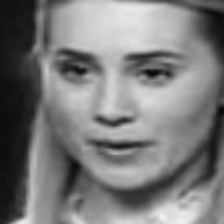

In [8]:
to_pil_transform = torchvision.transforms.ToPILImage()
to_pil_transform(dataset[42][1])

In [9]:
def train_triplet(model, data_loader, num_epochs, lr=0.001):
  model.train()
  loss = torch.nn.TripletMarginLoss()
  loss_history = []
  print(f'lr: {lr}')
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in range(1, num_epochs+1):
    loss_accum = 0
    loss_cnt = 0
    for xa, xp, xn in tqdm(data_loader, desc=f'train {epoch}/{num_epochs}'):
      ya = model(xa.to(device))
      yp = model(xp.to(device))
      yn = model(xn.to(device))
      loss_data = loss(ya, yp, yn)
      
      optimizer.zero_grad()
      loss_data.backward()
      optimizer.step()
      
      loss_accum += float(loss_data)
      loss_cnt += 1

    loss_value = loss_accum / loss_cnt
    loss_history.append(loss_value)
    print(f'loss: {loss_value}')

    if loss_value > loss_history[-1]:
      lr *= 0.1
      print(f'lr: {lr}')
      optimizer = optim.Adam(model.parameters(), lr=lr)

  return loss_history

In [10]:
import psutil
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=psutil.cpu_count())
psutil.cpu_count()

2

In [29]:
def create_faceid_model():
  model = torchvision.models.resnet50(weights='DEFAULT')
  model.fc = nn.Linear(model.fc.in_features, 16)
  return model

def grayscale_fix_model(model):
  w = model.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
  model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  model.conv1.weight.data = w
  return model

def set_trainable(model):
  model.requires_grad_(False)
  model.fc.requires_grad_(True)

def bind_model2device(model):
  model.to(device)

model = create_faceid_model()
model = grayscale_fix_model(model)
set_trainable(model)
bind_model2device(model)
#summary(model)
model.conv1, model.fc

(Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Linear(in_features=2048, out_features=16, bias=True))

lr: 0.001


train 1/10: 100%|██████████| 237/237 [01:21<00:00,  2.91it/s]


loss: 0.8208440145013957


train 2/10: 100%|██████████| 237/237 [01:19<00:00,  2.97it/s]


loss: 0.3231586200432687


train 3/10: 100%|██████████| 237/237 [01:20<00:00,  2.95it/s]


loss: 0.15241227481309874


train 4/10: 100%|██████████| 237/237 [01:20<00:00,  2.93it/s]


loss: 0.09516627206329555


train 5/10: 100%|██████████| 237/237 [01:21<00:00,  2.92it/s]


loss: 0.06260127943590724


train 6/10: 100%|██████████| 237/237 [01:20<00:00,  2.93it/s]


loss: 0.04590796401040464


train 7/10: 100%|██████████| 237/237 [01:20<00:00,  2.95it/s]


loss: 0.037243974752692734


train 8/10: 100%|██████████| 237/237 [01:20<00:00,  2.94it/s]


loss: 0.02860938631909809


train 9/10: 100%|██████████| 237/237 [01:19<00:00,  2.98it/s]


loss: 0.023727640431012786


train 10/10: 100%|██████████| 237/237 [01:19<00:00,  2.97it/s]


loss: 0.021411601061056437


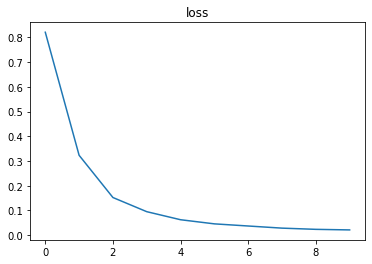

In [30]:
loss_history = train_triplet(model, data_loader, 10)
plt.plot(loss_history)
plt.title('loss');

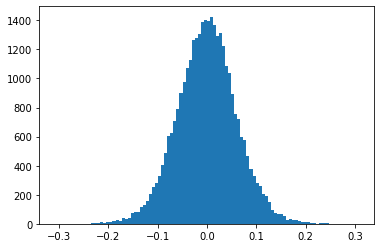

In [31]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [32]:
model(dataset[42][0].reshape(1, 1, 224, 224).to(device))

tensor([[ 0.0121, -0.4793, -0.2842,  0.6240,  0.7135, -0.5626, -0.0114,  0.0055,
          0.1419, -0.1138,  0.0712,  0.3647, -0.8611,  0.7116, -0.7001, -0.5960]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [33]:
def cos_similarity(v1, v2):
  val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
  return val.reshape(-1)[0]

def euc_similarity(v1, v2):
  return np.linalg.norm(v1-v2)

In [34]:
for i in range(10):
  v1 = model(dataset[42][0].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  v2 = model(dataset[42][1].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  v3 = model(dataset[42][2].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  print(euc_similarity(v1, v2), euc_similarity(v1, v3), cos_similarity(v1, v2), cos_similarity(v1, v3))

1.0177838 1.4450595 0.8874112 0.70600903
0.70529723 1.4450595 0.9326453 0.70600903
0.93960714 1.4450595 0.9382876 0.70600903
1.0804201 1.4450595 0.83386093 0.70600903
0.9210114 1.4450595 0.8835323 0.70600903
1.5565265 1.4450595 0.76984334 0.70600903
1.5130188 1.4450595 0.66834116 0.70600903
0.6016849 1.4450595 0.953812 0.70600903
0.80332583 1.4450595 0.9157129 0.70600903
1.6449538 1.4450595 0.68246067 0.70600903


lr: 1e-05


train 1/5: 100%|██████████| 237/237 [03:31<00:00,  1.12it/s]


loss: 0.01187690494794257


train 2/5: 100%|██████████| 237/237 [03:28<00:00,  1.14it/s]


loss: 0.0037039081381343084


train 3/5: 100%|██████████| 237/237 [03:26<00:00,  1.15it/s]


loss: 0.0030965611087119026


train 4/5: 100%|██████████| 237/237 [03:25<00:00,  1.15it/s]


loss: 0.0018840895234783993


train 5/5: 100%|██████████| 237/237 [03:24<00:00,  1.16it/s]

loss: 0.0006316132246190486


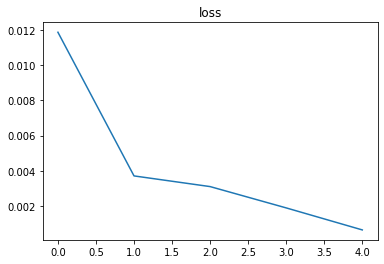

In [35]:
model.requires_grad_(True)
loss_history = train_triplet(model, data_loader, 5, lr=0.00001)
plt.plot(loss_history)
plt.title('loss');

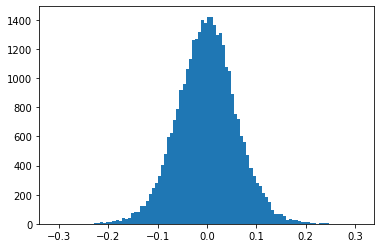

In [36]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [37]:
for i in range(10):
  v1 = model(dataset[42][0].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  v2 = model(dataset[42][1].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  v3 = model(dataset[42][2].reshape(1, 1, 224, 224).to(device)).cpu().detach().numpy()
  print(euc_similarity(v1, v2), euc_similarity(v1, v3), cos_similarity(v1, v2), cos_similarity(v1, v3))

1.2950876 2.4262524 0.96691644 0.50597876
1.0803049 2.4262524 0.9160541 0.50597876
1.6477917 2.4262524 0.7821677 0.50597876
0.9277491 2.4262524 0.9604089 0.50597876
1.162375 2.4262524 0.9029465 0.50597876
1.3480612 2.4262524 0.94795305 0.50597876
0.8192 2.4262524 0.95890594 0.50597876
0.98006445 2.4262524 0.9550934 0.50597876
0.9251302 2.4262524 0.9367603 0.50597876
1.3324863 2.4262524 0.9134741 0.50597876


In [38]:
torch.save(model, f'faceid-model-{loss_history[-1]}.pt')
!ls -l faceid-model-*.pt

-rw-r--r-- 1 root root 94474945 Sep 22 11:16 faceid-model-0.0006316132246190486.pt
-rw-r--r-- 1 root root 94474945 Sep 22 10:21 faceid-model-0.0007689715940741044.pt
